# Calibration of Neural Network

In this section we investigate calibrating a basic neural network using Platt scaling following ideas presented in the paper "On Calibration of Modern Neural Networks" found at https://proceedings.mlr.press/v70/guo17a/guo17a.pdf. The calibration problem for neural networks refers to the issue of aligning the predicted probabilities of a model with the true likelihood of the models predictions. As described in the paper, increasing the depth and width of a neural network negatively affects model calibration and so these networks require additional steps to be re-calibrated.

We will use a small neural network to investigate the effects of calibration, as the network is small it is already reasonably well calibrated but the techniques used here can easily be applied to larger neural networks where they are more important. The main purpose of this section is more to introduce and explain calibration than to see much improved results.

We use the same main dataset as is used throughout the project, found at https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset/data.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("Main dataset.csv")
data = df.to_numpy()

To keep the neural network as simple as possible we just use the 5 features listed as follows: average word length, average words per paragraph, average and standard deviation in sentence length and average difference between consecutive sentences. Impressively these features are enough for a simple neural network to achive an accuracy of around 88%.

In [4]:
def count_sentences_by_length(text):
    # Use regular expression to split the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Remove empty strings from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Count sentences with less than 11 words and more than 34 words
    count_less_than_11 = sum(1 for sentence in sentences if len(sentence.split()) < 11)
    count_more_than_34 = sum(1 for sentence in sentences if len(sentence.split()) > 34)

    return count_less_than_11, count_more_than_34

In [5]:
def average_sentence_length_difference(text):
    # Use regular expression to split the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Remove empty strings from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Calculate the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Calculate the difference in consecutive sentence lengths
    sentence_length_diff = [abs(sentence_lengths[i] - sentence_lengths[i - 1]) for i in range(1, len(sentence_lengths))]

    # Calculate the average difference in consecutive sentence lengths
    avg_sentence_length_diff = statistics.mean(sentence_length_diff) if sentence_length_diff else 0

    return avg_sentence_length_diff

In [6]:
import re
import statistics

def sentence_stats(text):
    # Use regular expression to split the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Remove empty strings from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Calculate the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Calculate the average sentence length
    avg_sentence_length = statistics.mean(sentence_lengths)

    # Calculate the standard deviation in sentence length
    if len(sentence_lengths) > 1:
        std_dev_sentence_length = statistics.stdev(sentence_lengths)
    else:
        std_dev_sentence_length = 0

    return avg_sentence_length, std_dev_sentence_length

In [7]:
def average_words_per_paragraph(text):
    paragraphs = text.split('\n\n')  # Split the text into paragraphs
    total_words = 0
    total_paragraphs = len(paragraphs)

    for paragraph in paragraphs:
        words = paragraph.split()  # Split each paragraph into words
        total_words += len(words)

    if total_paragraphs == 0:
        return 0  # Avoid division by zero if the input text has no paragraphs

    avg_words_per_paragraph = total_words / total_paragraphs
    return avg_words_per_paragraph

In [8]:
def average_word_length(input_string):
    words = input_string.split()  # Split the string into a list of words
    total_characters = sum(len(word) for word in words)
    total_words = len(words)

    if total_words == 0:
        return 0  # Avoid division by zero if the input string is empty

    avg_length = total_characters / total_words
    return avg_length

In [9]:
def feature_appender(dataset, text_index):
    features = []
    for essay in dataset:
        new_entry = []
        av_word_len = average_word_length(essay[text_index])
        new_entry.append(av_word_len)

        av_word_para = average_words_per_paragraph(essay[text_index])
        new_entry.append(av_word_para)

        mean_sentence_len, sd_sentence_len = sentence_stats(essay[text_index])
        new_entry.append(mean_sentence_len)
        new_entry.append(sd_sentence_len)

        consec_sen_diff = average_sentence_length_difference(essay[text_index])
        new_entry.append(consec_sen_diff)

        less_than_11, over_34 = count_sentences_by_length(essay[text_index])
        new_entry.append(less_than_11)
        new_entry.append(over_34)

        features.append(new_entry)
        
    return features

In [10]:
features = []
features = feature_appender(data, 0)
print(features[0])

[6.0834782608695654, 575.0, 20.535714285714285, 6.562983416309333, 6.666666666666667, 1, 0]


In [11]:
short_features = [lst[:-2] for lst in features]

In [12]:
labels = []
for essay in data:
    labels.append(essay[1])

In [13]:
!pip install tensorflow

  Using cached tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl

In [14]:
# We split the data before starting to keep some data completely unseen to test calibration
X_train, X_test, y_train, y_test = train_test_split(short_features, labels, test_size=0.2, random_state=42)

In [34]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Re-split data for training and evaluation
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



# Define a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid used for Binary Classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_tr, y_tr, epochs=10, batch_size=32, validation_data=(X_te, y_te))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10
583/583 [==============================] - 2s 3ms/step - loss: 0.6083 - accuracy: 0.7655 - val_loss: 0.5409 - val_accuracy: 0.7633
Epoch 2/10
583/583 [==============================] - 1s 2ms/step - loss: 0.4333 - accuracy: 0.8295 - val_loss: 0.4150 - val_accuracy: 0.8349
Epoch 3/10
583/583 [==============================] - 1s 2ms/step - loss: 0.3955 - accuracy: 0.8422 - val_loss: 0.4081 - val_accuracy: 0.8216
Epoch 4/10
583/583 [==============================] - 1s 2ms/step - loss: 0.3928 - accuracy: 0.8461 - val_loss: 0.4625 - val_accuracy: 0.7862
Epoch 5/10
583/583 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8563 - val_loss: 0.4238 - val_accuracy: 0.8255
Epoch 6/10
583/583 [==============================] - 1s 2ms/step - loss: 0.3390 - accuracy: 0.8662 - val_loss: 0.3501 - val_accuracy: 0.8669
Epoch 7/10
583/583 [==============================] - 2s 3ms/step - loss: 0.3344 - accuracy: 0.8667 - val_loss: 0.3500 - val_accuracy: 0.8593
Epoch 

To see how well calibrated the model already is we use the predicted probabilities to plot a reliability diagram and compute the Expected Calibration Error metric (ECE)

Reliability diagrams are constructed by dividing the predicted probabilities into $M$ bins of size $1/M$ .
For each bin we calculate the average predicted probability and determine the observed frequency
of positive outcomes. Plotting the average predicted probabilities against the observed frequencies
for each bin gives the reliability diagram where a perfect diagonal line $(y = x)$ indicates perfect
calibration. Deviations from the diagonal indicate miscalibration and so this technique provides a
useful visualization of whether a model is overconfident or underconfident in its predictions.

The ECE is calculated by taking a weighted average over the difference in accuracy and confidence for each bin. Expressed precisely as $\text{ECE} = \sum_{i=1}^M\frac{|B_i|}{n}\left|acc(B_i)-conf(B_i)\right|$
where $n$ is the number of samples, $B_i$ is the set of indices that fall into that bin, $acc(B_i)$ is the observed frequency of positive outcomes in $B_i$ and $conf(B_i)$ is the predicted probabilities for $B_i$. This is the primary empirical metric to measure calibration.

183/183 [==============================] - 0s 951us/step


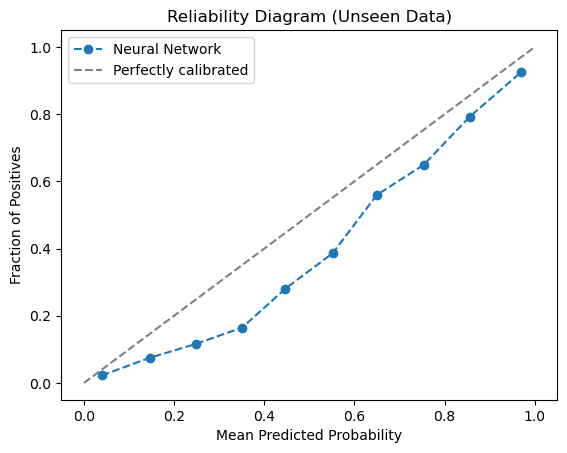

Expected Calibration Error (ECE): 0.2028


In [35]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, accuracy_score

# Obtain predicted probabilities
y_pred_prob = model.predict(X_test).flatten()

# Generate a reliability diagram
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

# Plot the reliability diagram
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (Unseen Data)')
plt.legend()
plt.show()

# Calculate the Expected Calibration Error (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bin_edges[1:-1])

    acc_diff = np.abs(y_prob - y_true)
    bin_counts = np.bincount(bin_indices, minlength=n_bins + 1)[1:-1]
    bin_weights = bin_counts / np.sum(bin_counts)
    ece = np.sum(acc_diff) / len(y_true)
    return ece

# Calculate ECE
ece = expected_calibration_error(y_test, y_pred_prob)
print(f'Expected Calibration Error (ECE): {ece:.4f}')

We can see form the diagram that the model is reasonably well calibrated but there is room for improvement, as the predictions are under the perfectly calibrated line we know that the model is underconfident in the predictions its making.

Its difficult to assess the ECE score without context, all we know is that the closer to zero the better. Comparing it to results from the paper and ECE score of 0.20 seems to be quite poor for such a small neural network.

Its worth mentioning that reproducibility with these results is not great when the neural network is re-run, however the main trends of the following results are fairly consistent

# Platt Scaling

Platt Scaling is arguably the most popular technique for calibrating binary calssification models. It is a parametric approach that simply uses the probabalistic predictions of the classifier as features for a seperate logistic regression model trained on the validation set. This may seem like cheating to train a seperate model, but we train it only on the same validation set that the neural network used and keep X_test and y_test as completely unseen data. When trained this way the neural network and logistic regression model can be used effectively in tandem. 

146/146 [==============================] - 0s 1ms/step


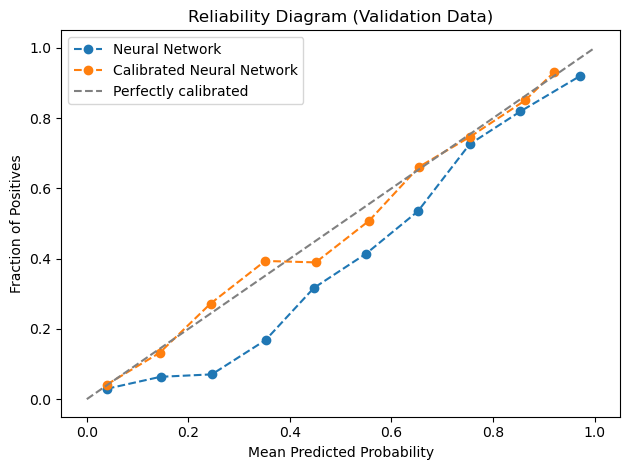

Calibration Error (ECE) before Platt Scaling: 0.2028
Calibration Error (ECE) after Platt Scaling: 0.1834


In [38]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Extract non-probabilistic predictions (logits) from the neural network
neural_network_logits = model.predict(X_te)

# Generate a reliability diagram
prob_true_val, prob_pred_val = calibration_curve(y_te, neural_network_logits, n_bins=10)

# Train a logistic regression model on the logits
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(neural_network_logits, y_te)

#  Tune parameters a and b to minimize NLL loss over the validation set
calibrated_classifier = CalibratedClassifierCV(logistic_regression_model, method='sigmoid', cv='prefit')
calibrated_classifier.fit(neural_network_logits, y_te)

# Now, use the calibrated classifier for predictions
calibrated_probs = calibrated_classifier.predict_proba(neural_network_logits)[:, 1]

# Generate a reliability diagram for the scaled probabilities
prob_true_scaled, prob_pred_scaled = calibration_curve(y_te, calibrated_probs, n_bins=10)

# Plot the original and scaled reliability diagrams for comparison
plt.figure()
plt.plot(prob_pred_val, prob_true_val, marker='o', linestyle='--', label='Neural Network')
plt.plot(prob_pred_scaled, prob_true_scaled, marker='o', linestyle='--', label='Calibrated Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (Validation Data)')
plt.legend()



plt.tight_layout()
plt.show()

# Calculate the Expected Calibration Error (ECE) after temperature scaling
ece_scaled = expected_calibration_error(y_te, calibrated_probs)
print(f'Calibration Error (ECE) before Platt Scaling: {ece:.4f}')
print(f'Calibration Error (ECE) after Platt Scaling: {ece_scaled:.4f}')


On the validation data we can see that the Platt scaling is successful in making more accurate predictions of confidence and the ECE has been reduced significantly. The real question though is do these results generalize to data unseen by either model? We test this below.

183/183 [==============================] - 0s 1ms/step


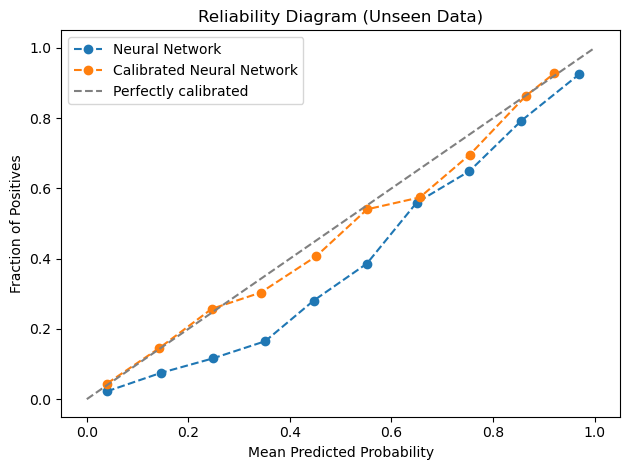

Calibration Error (ECE) before Platt Scaling: 0.2028
Calibration Error (ECE) after Platt Scaling: 0.1864


In [47]:
X = X_test
Y = y_test

neural_network_logits = model.predict(X)
calibrated_probs = calibrated_classifier.predict_proba(neural_network_logits)[:, 1]

# Generate a reliability diagram for the scaled probabilities
prob_true_scaled, prob_pred_scaled = calibration_curve(Y, calibrated_probs, n_bins=10)

# Plot the original and scaled reliability diagrams for comparison
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', label='Neural Network')
plt.plot(prob_pred_scaled, prob_true_scaled, marker='o', linestyle='--', label='Calibrated Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (Unseen Data)')
plt.legend()



plt.tight_layout()
plt.show()

# Calculate the Expected Calibration Error (ECE) after temperature scaling
ece_scaled = expected_calibration_error(Y, calibrated_probs)
print(f'Calibration Error (ECE) before Platt Scaling: {ece:.4f}')
print(f'Calibration Error (ECE) after Platt Scaling: {ece_scaled:.4f}')


As we would expect, the calibration after Platt Scaling is slightly worse but pleasingly still much better than the uncalibrated model providing evidence that the results generalise. There is still room for improvement as the calibrated model becomes underconfident for cases with predicted probability over 0.5. In context, this behaviour might be useful to reduce the numer of false accusations of generative AI used by students.

## A Word on Temperature Scaling

Initially the intention of this section was to use Temperature Scaling to calibrate the neural network as it is the best performing calibration method discussed in "On Calibration of Modern Nerural Networks". However, during implementation it became apparent that this technique is more suited to multi-class classification. This is because the scaling of the logits is closely associated with the softmax activation function and the technique doesnt seem to translate well when applied to the sigmoid function which we use for binary classification. The sigmoid activation function already squashes the logits between 0 and 1 and adding a temperature scaling factor to this is unlikely to improve upon the already well-calculated probabilities.

The attempted code has been left in below which incorrectly uses the softmax function, unfortunatly this method was never likely to work.

183/183 [==============================] - 0s 1ms/step


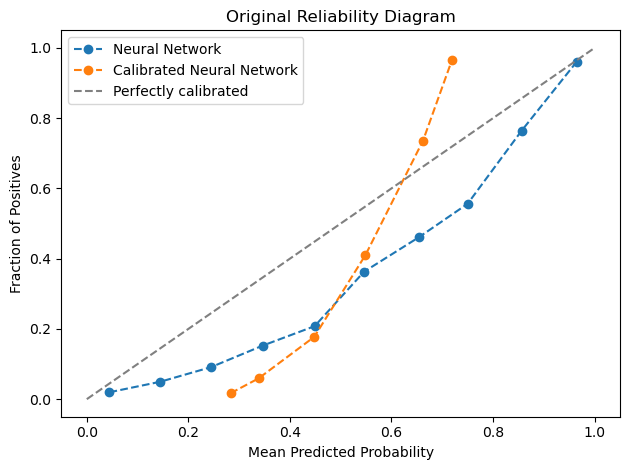

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, accuracy_score

# Obtain predicted logits before softmax
logits = model.predict(X_test)

# Calculate weights for the other class
opp_logits = np.array([1.0 - logit for logit in logits])

# Define the temperature
temperature = 1

# Apply temperature scaling
scaled_logits = logits / temperature
scaled_opp_logits = opp_logits / temperature

# Concatenate along axis=1 (assuming these are row vectors)
combined_logits = np.concatenate((scaled_logits, scaled_opp_logits), axis=1)

# Convert scaled logits to probabilities using softmax
scaled_probabilities = np.exp(scaled_logits) / (np.exp(scaled_logits) + np.exp(scaled_opp_logits))
#scaled_probabilities = softmax(combined_logits, axis=1)
#scaled_probabilities = 1/(1+np.exp(-scaled_logits))

# Normalize to ensure probabilities sum to 1 for each sample
#scaled_probabilities /= np.sum(scaled_logits, axis=1, keepdims=True)
#scaled_probabilities = scaled_probabilities[:, 0]
#scaled_probabilities = np.min(scaled_probabilities, axis=1)

# Convert scaled logits to probabilities using softmax
#scaled_probabilities = np.exp(combined_logits) / np.sum(np.exp(combined_logits), axis=1, keepdims=True)
#scaled_probabilities = np.max(scaled_probabilities, axis=1)
# Generate a reliability diagram for the scaled probabilities
prob_true_scaled, prob_pred_scaled = calibration_curve(y_test, scaled_probabilities, n_bins=10)

# Plot the original and scaled reliability diagrams for comparison
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', label='Neural Network')
plt.plot(prob_pred_scaled, prob_true_scaled, marker='o', linestyle='--', label='Calibrated Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Original Reliability Diagram')
plt.legend()
plt.tight_layout()
plt.show()

With a temperature of 1 we should see the calibrated network equal to the uncalibrated one and then we would go from there optimising T to minimise the ECE. Unfortunatly this never happened as its incorrect to use the softmax function to give scaled probabilities in a binary classification problem.